# Additional Exercise

Due: **12:00 18 July 2022**

**Online submission** at via [ILIAS](https://www.ilias.uni-koeln.de/ilias/goto_uk_exc_4593683.html) in the directory Exercises / Übungen -> Submission of Exercises / Rückgabe des Übungsblätter



## Information

This additional exercise may be used for **one** of two reasons:

* make up for the attendance requirement (if you missed more than two tutorials), or
* replace lowest grade in exercises (mentioned to you via email)

For the latter, you may submit the solutions to this like any other exercise this year. For experience, it is advantageous to still use the following procedure.

If you need to make up for the attendance requirement, you must use a specific method of submission utilising [github](https://github.com/) and a makefile. If you are using Windows, please ensure you work either in [cygwin](https://www.cygwin.com/) or [Windows Subsystem for Linux](https://docs.microsoft.com/en-us/windows/wsl/install), since `make` does not work in Windows.

1. create a repository on github exclusively for this exercise
2. fully complete (or at least attempt) each question in a jupyter notebook
   * name it `[name]_additional_exercise_solution.ipynb`
3. restart and clear all notebook ouputs so it contains just the markdown and code cells (no plots or other outputs)
4. create a makefile to execute the notebook, compile to a pdf, and remove any temporary files
   * I should only need to run `$make` in order to build your submission
   * **do not** submit a compiled pdf of the solution
5. submit a file `[name].txt` containing the link to your git repository

Although make is a rather archaic tool, `make` is very useful to perform low-level compilation. It actually began as an easier method to compile C** and fortran code. Common compilation routines are identified using *suffix rules*. **For an additional 10%, write your own suffix rule to compile `.ipynb` files into `.pdf`.**

## `MakeFile`s

What a makefile does is simplify a workflow using terminal commands. As mentioned above, it is useful to compile documentation/code if changes where made in the source. One can in fact use this for newer formats such as IPython notebooks (`.ipynb` files).

A makefile typically goes in the top directory of your project. You can find an introduction to makefiles [here](https://makefiletutorial.com/). Basically how a makefile works is that you have a series of *targets* that execute a specific set of commands. For example, if your makefile contains,

```
info:
    @echo "This is a makefile."

command:
    @echo "This is a command."
```

> *Note:* Make will by default also print each command. Beginning the command with `@` suppresses this functionality.

you can make either target `info` or target `command`. Running `make info` in the terminal from the top directory will print `This is a makefile.` to the terminal. Likewise running `make command` will print `This is a command.` to the terminal. Not specifying a target will make the first target in the file (so `make info` is the same as `make` in this example). For this reason, it is customary to set the first target as the default workflow. If our makefile now contains,

```
all: info command

info:
    @echo "This is a makefile."

command:
    @echo "Some commands to execute:"
    echo "..."
    @echo "It has now completed."
```

running `make` from the terminal will print,

```
This is a makefile.
Some commands to execute:
echo "..."
...
It has now completed.
```

Each target can run multiple commands, but each line is run in a separate subshell. This means if you want to string together commands (for example if you need to change directories), you have to write them in one line as `command 1 ; command 2 ; ...`.

This should be most everything you need to write your own makefile. Please contact a TA if you run into any major issues.

> Ensure each command is indented with a **tab** character (not *space* characters). This is one of the finicky aspects of using a makefile...

> Note that linux operating systems use GNU make with `bash` or `dash` as a shell. Macintosh products typically use `zsh`.

## Working with a notebook from the terminal

Most operations you can perform on the notebook are available from the terminal. The command to work with notebooks is [nbconvert](https://nbconvert.readthedocs.io/en/latest/usage.html). This can convert between file types, depending on your needs. For example, executing a notebook from the terminal can be done using,

```
jupyter nbconvert --to notebook --execute notebook.ipynb
```

You can see a list of the available format types in the aforementioned link.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

## the *Hipparcos* catalogue

*Hipparcos* (HIgh Precision PARallax COllecting Satelite) was a very important stellar survey mission between 1989 and 1993. It was the first astrometric mission of its kind, and it's precise observations allowed for unprecedented astrometrical calculations within the Milky Way. The observations of faint stars have since been (*vastly*) improved upon by the current *Gaia* mission, though the brightest stars were still most accurately observed by *Hipparcos*.

The following examples will utilise a subset of a more recent reduction of the *Hipparcos* [data](https://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=I/311/hip2) ([van Leeuwen 2007](https://arxiv.org/pdf/0708.1752.pdf)) to emphasize how work with astronomical data within python, and hopefully teach a thing or two about stellar populations. The dataset we use are the stars with five-parameter astrometric solutions, meaning the solutions have been constrained for RA and DEC, proper motion in RA and DEC, and parallax. We will also highlight some of the features of various python packages so you can decide which method you prefer.

This dataset has 15 columns, with the titles as a comment in the first line. The columns (and units) are,

 - name in the *Hipparcos* catalog HIP
 - right ascentions RA ($\mathrm{RA}$; degrees)
 - error in right ascention sigma_RA ($\sigma_\mathrm{RA}$; milli-arcseconds)
 - declination DEC ($\mathrm{DEC}$; degrees)
 - error in declination sigma_DEC ($\sigma_\mathrm{DEC}$; milli-arcseconds)
 - parallax PLX ($\varpi$; in milli-arcseconds)
 - error in parallax sigma_PLX ($\sigma_\mathrm{\varpi}$; in milli-arcseconds)
 - right ascention proper motion PM_RA ($\mu_\mathrm{RA}$; milli-arcseconds per year)
 - error in right ascention proper motion sigma_PM_RA ($\sigma_{\mu, \mathrm{RA}}$; milli-arcseconds per year)
 - declination proper motion PM_DEC ($\mu_\mathrm{DEC}$; milli-arcseconds per year)
 - error in declination proper motion sigma_PM_DEC ($\sigma_{\mu, \mathrm{DEC}}$; milli-arcseconds per year)
 - *Hipparcos* magnitude Hp (dex)
   - *aka* V-band magnitude
 - error in magnitude sigma_Hp (dex)
 - B-V color (dex)
 - error in B-V color sigma_B-V (dex)
 - V-I color (dex)

### Calculating distance

A major benefit to precise astrometric observations is an accurate estimate of the parallax. This allows us to calculate the distance to each star and it reveal the structure of the Milky Way.

Begin by using the parallax ($\varpi$) to calculate the distance in parsecs (pc) to each star. It is important to remember that the parallax has units of milli-arcseconds (mas), so the distance to the star is calculated by:

$$ d = 1000 \Big(\frac{\mathrm{mas}}{\varpi}\Big) \ \mathrm{pc} $$

Use this formula to find some interesting trends in the *Hipparcos* catalog. Are there any issues with the dataset? **5 points**

> *Note:* Each degree contains 60 arcminutes, which each contain 60 arcseconds, so there are 3 600 000 milli-arcseconds in 1 degree.

> *Note:* The Milky Way has a diameter of $\sim 40~000$ pc and Earth is located at a radius of $\sim 8~000$ pc.

In [3]:
data = pd.read_csv('hipparcos2.csv', sep=',')
data

,# HIP,RA,sigma_RA,DEC,sigma_DEC,PLX,sigma_PLX,PM_RA,sigma_PM_RA,PM_DEC,sigma_PM_DEC,Hp,sigma_Hp,B-V,sigma_B-V,V-I
0,HIP 1,0.000912,1.29,1.089013,0.66,4.55,1.33,-4.55,1.25,-1.19,0.75,9.2043,0.0020,0.482,0.025,0.55
1,HIP 2,0.003797,0.95,-19.498837,0.53,20.85,1.13,182.88,1.22,-1.31,0.66,9.4017,0.0017,0.999,0.002,1.04
2,HIP 3,0.005008,0.31,38.859286,0.21,2.26,0.36,4.27,0.34,-3.43,0.27,6.6081,0.0006,-0.019,0.004,0.00
3,HIP 4,0.008382,0.40,-51.893546,0.47,7.45,0.77,62.64,0.51,0.19,0.51,8.1498,0.0011,0.370,0.009,0.43
4,HIP 5,0.009965,0.55,-40.591224,0.50,3.88,0.95,1.89,0.58,8.06,0.64,8.7077,0.0018,0.902,0.013,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117950,HIP 120313,206.398693,3.77,17.742441,4.04,5.36,2.06,-4.61,3.09,-3.18,2.88,9.5172,0.0029,1.430,0.020,1.40
117951,HIP 120401,119.382277,7.23,-60.630932,7.32,1.82,2.68,-7.62,6.90,21.56,6.91,9.2339,0.0084,0.104,0.007,0.12
117952,HIP 120402,119.448662,4.48,-60.609727,4.53,2.98,1.46,-7.25,4.14,4.47,4.25,8.3699,0.0030,-0.022,0.010,0.00
117953,HIP 120403,119.454927,4.69,-60.683660,4.70,0.85,1.94,-8.50,4.31,15.81,4.53,8.5790,0.0039,0.061,0.007,0.07


In [8]:
filtering_PLX = data['PLX']>data['sigma_PLX']
filtered_PLX = filtering_PLX*data['PLX']
#i dont like it

#filtering the values where the error is bigger then the value it self and safe as 0

In [9]:
filtered_PLX.replace([np.inf, 0, -np.inf], np.nan, inplace=True)
#replace +-inf and 0 with nan 

In [43]:
data['Distance (pc)'] = (1000/filtered_PLX)
distance = np.asanyarray(data['Distance (pc)'])
# we took the abs of the values because negativ PLX HAS no PYSICLEMEANING

In [50]:
import itertools
import operator

def most_common(L):
  # get an iterable of (item, iterable) pairs
  SL = sorted((x, i) for i, x in enumerate(L))
  # print 'SL:', SL
  groups = itertools.groupby(SL, key=operator.itemgetter(0))
  # auxiliary function to get "quality" for an item
  def _auxfun(g):
    item, iterable = g
    count = 0
    min_index = len(L)
    for _, where in iterable:
      count += 1
      min_index = min(min_index, where)
    # print 'item %r, count %r, minind %r' % (item, count, min_index)
    return count, -min_index
  # pick the highest-count/earliest item
  return max(groups, key=_auxfun)[0]

In [51]:
print(most_com

183.4862385321101


In [45]:
print(np.bincount(distance).argmax())

TypeError: Cannot cast array data from dtype('float64') to dtype('int64') according to the rule 'safe'

In [48]:
from collections import Counter

def most_common(lst):
    data = Counter(lst)
    return max(lst, key=data.get)

In [49]:
most_common(distance)

TypeError: '>' not supported between instances of 'NoneType' and 'int'

Text(0, 0.5, 'Quantity')

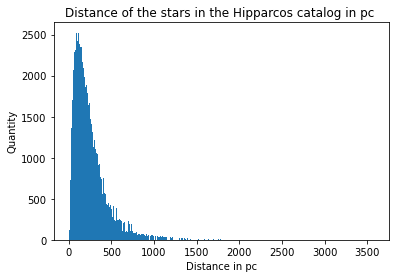

In [18]:
plt.hist(distance,bins = 500)
plt.title('Distance of the stars in the Hipparcos catalog in pc ')
plt.xlabel('Distance in pc')
plt.ylabel('Quantity')

Can you find what is the most common distance to a star? What is the standard deviation of this value? What can you determine from these values? **5 points**

In [7]:
print(data['Distance (pc)'].mean(skipna=True))
print(data['Distance (pc)'].std(skipna=True))

251.07377752456463
205.91340575411948


### By looking at the mean value , you can say the most common distance is about 251pc, which also can be seen in the histogram above. But there is a huge diffrents between the distance which can be seen at the standard deviation value. 

### Utilising error

Error is a major aspect of observational data, since there are so many sources (instrumentational and physical) to consider. Following the procedure of van Leeuwen (2007), let us examine the error in parallax and its trends in our dataset. Relative error $\big(\frac{\sigma_q}{q}\big)$ is an important metric when our data spans multiple orders of magnitude. What is the distribution of relative error in parallax (you may want to make y log-spaced)? What does this mean in terms of *Hipparcos*' precision? **10 points**

In [8]:
#data['PLX'].replace([np.inf, 0, -np.inf], np.nan, inplace=True)
#data['sigma_PLX'].replace([np.inf, 0, -np.inf], np.nan, inplace=True)

In [56]:
#relativ error
data['Relativ error PLX'] = data['sigma_PLX']/data['PLX']
Relativ_error_PLX = np.asarray(data['Relativ error PLX'])
Relativ_error_PLX.replace([np.inf, 0, -np.inf], np.nan, inplace=True)

AttributeError: 'numpy.ndarray' object has no attribute 'replace'

In [55]:
data['Relativ error PLX'].plot.hist(logy=True)

ValueError: autodetected range of [-325.0, inf] is not finite

The error in parallax is typically related to the brightness of the star (from the statistics of photon counts). A view of this trend can be seen below (keeping the relative parallax error below 5%; similar to Figure 11 in van Leewen 2007). Can you find a fit to this relation, including error? **10 points**

![relative error](./hipparcos_plx_err.png)

In [11]:
rel_error_filtering = data['Relativ error PLX'] <= 0.05 
rel_error_filtered = rel_error_filtering* data['sigma_PLX']

In [12]:
rel_error_filtered.replace([np.inf, 0, -np.inf], np.nan, inplace=True)

In [13]:
rel_error_filtered_np = np.asarray(rel_error_filtered)
magnitude = np.asarray(data['Hp'])

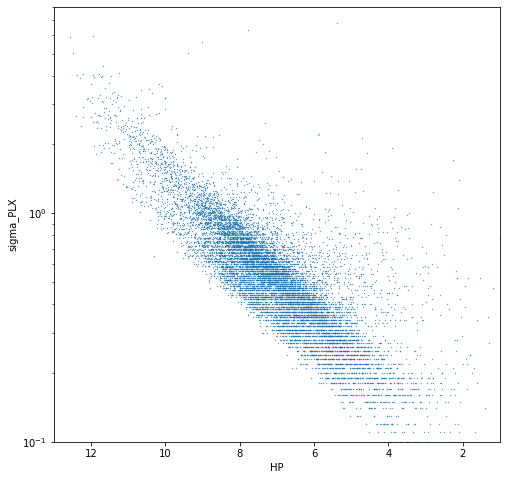

In [14]:
plt.rcParams["figure.figsize"] = (8,8)

plt.scatter(x=magnitude,y=rel_error_filtered_np,s=0.1)
plt.yscale('log')
plt.ylim((0.1,8))
plt.xlim((1,13))
plt.xlabel("HP")
plt.ylabel("sigma_PLX")
plt.gca().invert_xaxis()

Can you plot a histogram of the relative errors in $\mathrm{RA}, \ \mathrm{DEC},$ and $\mathrm{PLX}$ in a single figure? **10 points**

In [15]:
data['Relativer error RA'] = data['sigma_RA']/data['RA']
#data['Relativer error RA'].replace([np.inf, 0, -np.inf], np.nan, inplace=True)
RA = np.asarray(data['Relativer error RA'])

data['Relativer error DEC'] = data['sigma_DEC']/data['DEC']
#data['Relativer error DEC'].replace([np.inf, 0, -np.inf], np.nan, inplace=True)
DEC = np.asarray(data['Relativer error DEC'])


data['Relativer error PLX'] = data['sigma_PLX']/data['PLX']
data['Relativer error PLX'].replace([np.inf, 0, -np.inf], np.nan, inplace=True)
PLX = np.asarray(data['Relativer error PLX'])



In [16]:
RA

array([1.41447368e+03, 2.50197524e+02, 6.19009585e+01, ...,
       3.75056524e-02, 3.92616706e-02, 2.92857244e-02])

(array([1.00000e+00, 5.00000e+00, 1.90000e+01, 4.20000e+01, 1.17336e+05,
        4.66000e+02, 2.90000e+01, 1.20000e+01, 3.00000e+00, 3.00000e+00]),
 array([-325. , -258.1, -191.2, -124.3,  -57.4,    9.5,   76.4,  143.3,
         210.2,  277.1,  344. ]),
 <BarContainer object of 10 artists>)

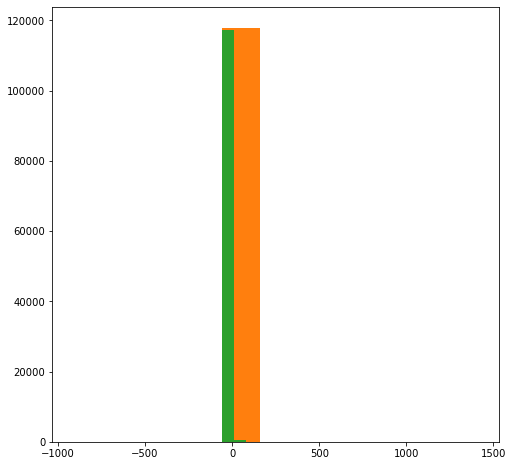

In [17]:
plt.figure()
plt.hist(RA)
plt.hist(DEC)
plt.hist(PLX)
#plt.xlim((0,200))

### Hertzsprung-Russell diagrams

#### Observational

Before calculating any intrinsic stellar properties from the observations, it is typically useful to plot a diagram of what you *observe*. (Observed here means the most basic properties that can be determined from the data. If you want to be pedantic, then you might suggest that the values in this table are not what is actually observed, but a reduction of the observed photon counts.) For this purpose we should plot a Hertzsprung-Russel diagram (HRD) to reveal the different stellar types. It is important not only to remember that a HRD has colour (B-V) on the x-axis and magnitude (Hp) on the y-axis, but also that the y-axis is reversed (the perks of using an antiquated unit). **5 points**

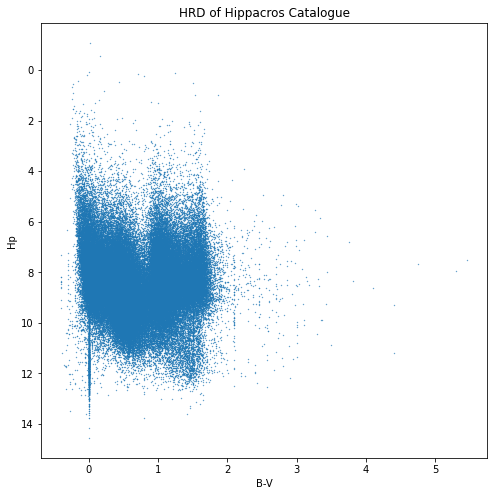

In [18]:
data.plot.scatter(x = 'B-V',y = 'Hp',s=0.1)
plt.title('HRD of Hippacros Catalogue')
plt.gca().invert_yaxis()

What do you see?

If you use the magnitude given in `hipparcos2.csv`, you might have a little difficulty determining the different regions of an HR diagram. One reason for this is that it is an apparent magnitude, so these results do not take into account reddening or extinction. Another issue, however, is that we don't filter the results that have a lot of error. Try plotting it again while limiting the relative parallax error to <20% and the color error to 5 mag. **5 points**

In [53]:
PLX_error = data['sigma_PLX']/data['PLX']<0.2
Color_error = data['sigma_B-V']<0.5

PLX_Color_limit = PLX_error * Color_error

B_V_limit = data['B-V']*PLX_Color_limit
B_V_limit_np = np.asarray(B_V_limit)
Hp_limit = data['Hp']*PLX_Color_limit
Hp_limit_np = np.asarray(Hp_limit)

/Users/marcel/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


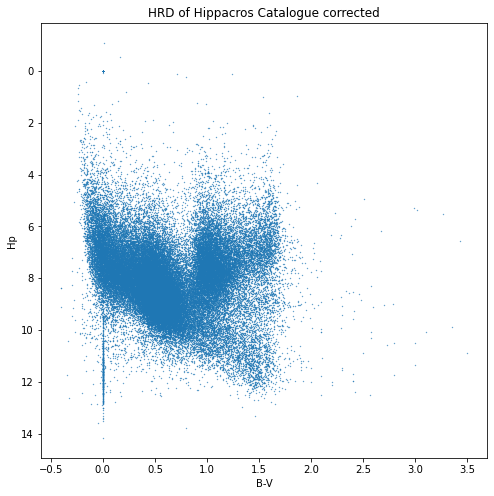

In [55]:
plt.scatter(x = B_V_limit_np, y = Hp_limit_np, s = 0.1)
plt.title('HRD of Hippacros Catalogue corrected')
plt.xlabel('B-V')
plt.ylabel('Hp')
plt.gca().invert_yaxis()

One trait now looks more prominent, and that is the suspiciously high number of stars with $ B-V = 0 $. This is called an artefact, and it is a result of some bad data or sloppy reduction. Since the author of this reduction is quite renowned in the community, the issue most likely lies with bad data for these stars. For the rest of the exercise, you may filter-out star with $B-V = 0$.

Now try plotting the HRD in terms of the intrinsic absolute magnitude, $ M_{Hp} $ (you should get something similar in shape to [this](https://www.cosmos.esa.int/documents/532822/573165/f3_5_005.pdf/90951100-6586-4ba7-a042-784f5845a279)). **Try also with the other colour $V-I$**. Remember that the absolute magnitude can be calculated by the formula:

$$
M_\mathrm{Hp} = m_\mathrm{Hp} - 5 \ \mathrm{log}_\mathrm{10}\Big(\frac{d}{pc}\Big) + 5
$$

This plot has a bit of an issue where there are many points plotted ontop of each other. Instead, see if you can plot the number density in a 2D histogram of of the following ways **10 points**

* bin the data in steps of 0.05 mag in $M_{Hp}$ and 0.01 mag in $B-V$, with the number density in the color bar. You might find the function `scipy.stats.binned_statistic_2d()` useful.
* Utilise the `hexbin` routine with an adequate choice of binning

In [144]:
B_V_limit_np_new= np.where(B_V_limit_np==0, np.nan, B_V_limit_np)

In [145]:
data['MHP'] = (data['Hp'])-(5*np.log(data['Distance (pc)']))+5
MHP = np.asarray(data['MHP'])

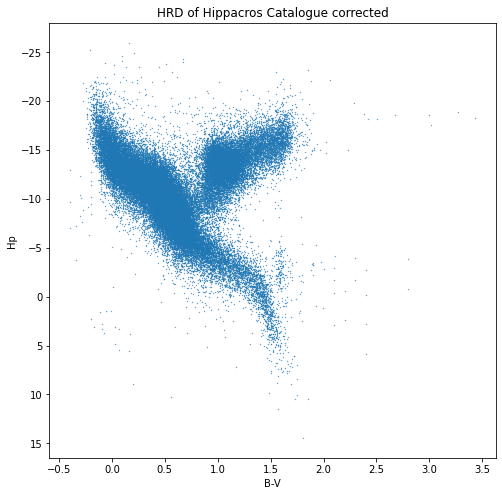

In [151]:
plt.scatter(x = B_V_limit_np_new, y = MHP, s = 0.1)
plt.title('HRD of Hippacros Catalogue corrected')
plt.xlabel('B-V')
plt.ylabel('Hp')
plt.gca().invert_yaxis()

In [153]:
B_V_new= np.where(B_V_limit_np_new==np.nan, 0, B_V_limit_np_new)
MHP_new= np.where(MHP==np.nan, 0, MHP)

In [156]:
from scipy import stats
z=np.arange(len(MHP_new))
print ("\nbinned_statistic_2d for count : ", 
       stats.binned_statistic_2d(B_V_new, MHP_new, values=z, 
                statistic ='count', bins = [5, 5]))

ValueError: cannot convert float NaN to integer

Very broadly we say that the features observed here are the main sequence (diagonal feature) and red clump (roughly spherical feature). Fit a line to the main sequence. Approximate the percentage of stars in the main sequence compared to the percentage in the red clump. **10 points**

> *Note:* This will not add up to 100%.

#### Theoretical

For theorists it is more illuminating to plot diagrams of intrinsic properties. This makes it easier to relate the observations to population synthesis or evolutionary models. Getting to these intrinsic stellar properties from our observations is typically quite involved, requiring some (not so trivial) estimate of the dust extinction and attenuation along the line of sight. We will assume there is no dust extinction for a very basic example.

A star's colour can be used to calculate its effective (surface) temperature. Disregarding any reddenning, we can estimate it using the formula ([Ballesteros 2012](https://arxiv.org/pdf/1201.1809.pdf)):

$$
T_\mathrm{eff} = 4600 \ \Big( \frac{1}{0.92(B-V)+0.62} + \frac{1}{0.92(B-V)+1.7} \Big) \ \mathrm{K}
$$

Luminosity is the intrinsic analog of magnitude. To put it in solar units, we need to use the absolute bolometric magnitude of the Sun ($M_\odot=4.74$) with the observed star's bolometric magnitude and extinction. Since our absolute magnitudes are in the V band, we will have to add a bolometric correction ($BC_\mathrm{Hp}$) to convert to the bolometric magnitude. Thus we have too many unknowns for our to make an accurate approximation. Current missions (ie. *Gaia*) get around this by utilising extremely-randomised trees, a regression method beyond the scope of this simple introduction. We will **not** use regression, but instead use an extremely-simplified approach where we neglect extinction and interpolate the bolometric correction (from `BC_hipparcos.csv`; [Masana et al. 2008](https://arxiv.org/pdf/astro-ph/0601049.pdf)) to get the formula:

$$
-2.5 \ \mathrm{log_{10}} \Big( \frac{L}{L_\odot} \Big) = M_\mathrm{Hp} + BC_\mathrm{Hp}(T_\mathrm{eff}) - M_\odot
$$

Finally, the stellar radii can be calculated using the standard blackbody relation:

$$
L = \Big( \frac{R}{R_\odot} \Big)^2 \Big( \frac{T_\mathrm{eff}}{T_{\mathrm{eff},\odot}} \Big)^4 \ L_\odot
$$

It might also help you to know the solar units: $L_\odot=3.828*10^{26} \ \mathrm{W}$, $R_\odot=6.956*10^8 \ \mathrm{m}$, $T_\odot=5780 \ \mathrm{K}$.

Perform a spline fit of the bolometric correction data. Correctly interpolate the BC and utilise the equations to create a 2D histogram (or hexbin plot) of $L$ as a function of $T_\mathrm{eff}$. **10 points**

> *hint:* Use units of $L_\odot$ and K.

> *hint:* Technically this fit is only valid for $T_\mathrm{eff} \in [3300, 8000]$ K.

In [118]:
data_2 = pd.read_csv('BC_hipparcos.csv', sep=',')

In [123]:
data_2['Luminosity'] = 10**((0.4*(4.74-data['MHP']-data_2['BC'])))

<AxesSubplot:xlabel='# Teff', ylabel='Luminosity'>

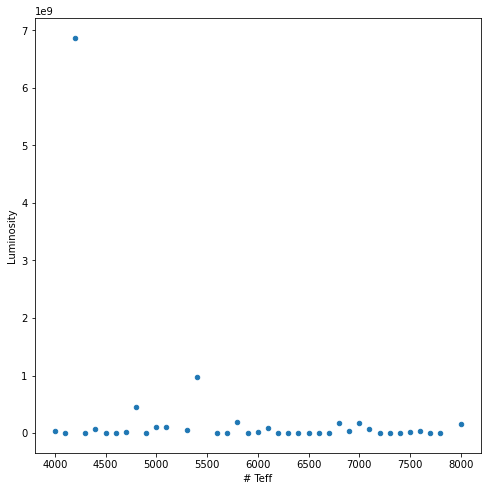

In [124]:
data_2.plot.scatter(x = '# Teff',y = 'Luminosity')

Now try to perform a linear fit to the main sequence, accounting for error. Estimate the error in the fit. **10 points**

Figure out how to isolate the stars on the main sequence. What is the probability for a star to be on the main sequence? Use the bootstrapping technique to determine the constrain the error in this approximation. **10 points**